In [1]:
N_TEST_BATCHES = 20

## Setup

In [2]:
import sys; sys.path.append('..')

In [3]:
# ! pip install lovely-tensors

import lovely_tensors as lt
lt.monkey_patch()

In [4]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import DataLoader

from transformer_lens import HookedTransformer, HookedTransformerConfig

In [5]:
import wandb
from tqdm.auto import tqdm

from omegaconf import OmegaConf

from datetime import datetime

from pathlib import Path

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from src.tree import list2tree
from src.tree_dataset import TreeDataset, parse_input_idx, input_tokens_to_tree, tree_to_edges
from src.utils import seed_all


from src.trainer import accuracy_by_depth
from src.trainer import TreeTrainer

In [7]:
conf = OmegaConf.load('../conf/00_reproduce_6L_nodes=16.yaml')

# Output is identical to the YAML file
conf.n_nodes = 16
conf.device = 'cpu'
print(OmegaConf.to_yaml(conf))

random_seed: 42
n_nodes: 16
model:
  d_model: 128
  d_head: 128
  n_layers: 6
  act_fn: gelu
  attention_dir: causal
optimizer:
  lr: 0.001
  weight_decay: 0.01
batch_size: 64
epoch_len_steps: 5000
checkpoint_every_epoch: 2
device: cpu
debug: false
use_wandb: true
wandb:
  project: reasoning-mech-interp
  name: 00_6L_nodes=16
max_iters: null



In [8]:
REPRODUCED_MODEL_CKPT = '../checkpoints/reasoning-mech-interp__2024-04-10_16-10-20/00_6L_nodes=16__step=220000.pt'
# REPRODUCED_MODEL_CKPT = '../checkpoints/reasoning-mech-interp__2024-04-12_14-26-20/00_6L_nodes=16__deep_trees__step=9256.pt'

In [9]:
DEV_RUN = False
USE_WANDB = (not DEV_RUN) and conf.use_wandb
device = conf.device

CHECKPOINT_ROOT = Path('../checkpoints')

In [10]:
RANDOM_SEED = conf['random_seed']
print(f'{RANDOM_SEED=}')
seed_all(RANDOM_SEED)

RANDOM_SEED=42


In [11]:
trainer = TreeTrainer(conf)

tokenizer = trainer.dataset.tokenizer

tok = tokenizer.tokenize
detok = tokenizer.detokenize


ROOT_DELIM_TOKEN_IDX = trainer.tok([':'])[0]

state_dict = torch.load(REPRODUCED_MODEL_CKPT)
trainer.model.load_state_dict(state_dict)

Moving model to device:  cpu


<All keys matched successfully>

In [12]:
def load_baseline_model(device='cpu'):
    n_states = 16
    max_seq_length = n_states * 4 + 2
    
    number_tokens = sorted([str(i) for i in range(n_states)], key=lambda x: len(x), reverse=True)
    idx2tokens = [",", ":", "|"] + [f">{t}" for t in number_tokens] + number_tokens
    tokens2idx = {token: idx for idx, token in enumerate(idx2tokens)}
    
    
    cfg = HookedTransformerConfig(
        n_layers=6,
        d_model=128,
        n_ctx=max_seq_length - 1,
        n_heads=1,
        d_mlp=512,
        d_head=128,
        #attn_only=True,
        d_vocab=len(idx2tokens),
        device=device,
        attention_dir= "causal",
        act_fn="gelu",
    )
    model = HookedTransformer(cfg)
    
    model.load_state_dict(torch.load("/Users/mykhailokilianovskyi/src/backward-chaining-circuits/model.pt", map_location=torch.device(device)))
    
    return model

In [13]:
import random
import collections
from torch.utils.data import IterableDataset, DataLoader

In [14]:
import random

from src.tree import TreeNode
from src.utils import seed_all
from src.tree_dataset import random_tree_of_depth, DeepTreeDataset

In [15]:
deep_dataset = DeepTreeDataset(n_nodes=16, possible_depths=(15,14,13))
deep_tree_dataloader = DataLoader(deep_dataset, batch_size=conf['batch_size'])

In [16]:
baseline_model = load_baseline_model()

### Setup Linear Probe

In [17]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split


from torch import nn


class LogisticRegressionModel(nn.Module):
    def __init__(self, n_features, n_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(n_features, n_classes)
    
    def forward(self, x):
        return self.linear(x)

# Assuming n_features is the number of features in your dataset and n_classes is the number of classes


In [18]:
from torch.utils.data import DataLoader, TensorDataset

def run_logreg(X,y, num_epochs=5, verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    logreg = LogisticRegressionModel(X_train.shape[1], len(np.unique(y_train)))
    
    logreg_train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(logreg_train_dataset, batch_size=64, shuffle=True)
    
    logreg_test_dataset = TensorDataset(X_test, y_test)
    logreg_test_loader = DataLoader(logreg_test_dataset, batch_size=64, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(logreg.parameters(), lr=0.001)
    
    
    train_losses = []
    train_accuracies = []
    
    test_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        logreg.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = logreg(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in logreg_test_loader:
    
            with torch.inference_mode():
                outputs = logreg(inputs)
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        epoch_loss = running_loss / len(logreg_test_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        if verbose:
            print(f'Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_accuracy:.2f}%')
    return epoch_accuracy

In [19]:
our_idx2token = trainer.dataset.tokenizer.idx2token


n_states = 16
bas_max_seq_length = n_states * 4 + 2

number_tokens = sorted([str(i) for i in range(n_states)], key=lambda x: len(x), reverse=True)
idx2tokens = [",", ":", "|"] + [f">{t}" for t in number_tokens] + number_tokens
tokens2idx = {token: idx for idx, token in enumerate(idx2tokens)}

from src.tree_dataset import PAD_TOKEN


token2bastoken = {k.replace('>', '→'):k for k in tokens2idx.keys()}
token2bastoken[PAD_TOKEN] = ','



idx2basidx = {}
for idx, our_tok in our_idx2token.items():
    bastoken = token2bastoken[our_tok]
    basidx = tokens2idx[bastoken]
    idx2basidx[idx] = basidx

In [20]:
def baseline_batch_train_step(baseline_model, batch):
    
    input_idx = batch['input_idx'][..., :bas_max_seq_length].clone().to(device)
    mask = batch['task_mask'][..., :bas_max_seq_length].clone().to(device)

    input_idx.apply_(lambda i: idx2basidx[i])

    inputs = input_idx[:, :-1]
    
    out_mask = mask[:, 1:]
    targets = input_idx[:, 1:][out_mask]
    
    
    # print(input_idx[:1, :4])
    outputs = baseline_model(inputs)
    
    predictions = outputs[out_mask]
    
    loss = F.cross_entropy(predictions, targets)

    is_correct = (predictions.argmax(dim=-1) == targets)
    accuracy_mean = is_correct.float().mean()
    metrics = accuracy_by_depth(outputs, input_idx, out_mask)
    metrics['accuracy/mean'] = accuracy_mean.item()

    return loss, metrics

In [21]:

ROOT_DELIM_TOKEN_IDX = trainer.tok([':'])[0]

def extract_edges(sample_input_idx):
    upper_task_bound = sample_input_idx.tolist().index(ROOT_DELIM_TOKEN_IDX) + 2
    prompt = trainer.detok(sample_input_idx)[:upper_task_bound]
    
    i = 2
    
    edges = []
    
    while i < len(prompt) and prompt[i] != '|':
        edge = (prompt[i-2], prompt[i-1])
        edges.append(edge)
        i += 3
    
    return edges


n_nodes = 16

edges = [(str(i), '→'+str(j)) for i in range(n_nodes) for j in range(n_nodes)]

edge2idx = {e:i for i,e in enumerate(edges)}

idx2edge = {i:e for e,i in edge2idx.items()}
print(f'{len(edge2idx)=}')

def get_first_node(edge_idx): return int(idx2edge[edge_idx][0])
def get_second_node(edge_idx): return int(idx2edge[edge_idx][1][1:])
    

def get_edge_labels(batch):
    input_idx = batch['input_idx']
    edge_batch = []
    for row in input_idx:
        edges = extract_edges(row)
        edges = [edge2idx[e] for e in edges]
        edge_batch.append(edges)
    return torch.tensor(edge_batch)

len(edge2idx)=256


## Check that goal node is moved

### Reproduce "edge token" detection

In [22]:
third_token_idx = torch.arange(2, 14*3, 3)
third_token_idx.v

tensor[14] i64 x∈[2, 41] μ=21.500 σ=12.550
tensor([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41])

In [23]:
cache_keys = [{'key': 'resid_post', "n": n} for n in range(6)]
cache_keys = [{'key': 'embed', 'n': None}] + cache_keys
cache_keys = [
    {'key': 'embed', 'n': None}, # just embeddings as a control experiment
 {'key': 'resid_post', 'n': 0},
 {'key': 'resid_post', 'n': 1},
 {'key': 'resid_post', 'n': 2},
 {'key': 'resid_post', 'n': 3},
 {'key': 'resid_post', 'n': 4},
 {'key': 'resid_post', 'n': 5}]



In [24]:
for batch in deep_tree_dataloader:
    break

In [25]:
torch.inference_mode()
def get_cache_baseline_model(batch, baseline_model):
    input_idx = batch['input_idx'][..., :bas_max_seq_length].clone().to(device)
    mask = batch['task_mask'][..., :bas_max_seq_length].clone().to(device)

    input_idx.apply_(lambda i: idx2basidx[i])

    inputs = input_idx[:, :-1]
    
    out_mask = mask[:, 1:]
    targets = input_idx[:, 1:][out_mask]
    
    
    # print(input_idx[:1, :4])
    # outputs = baseline_model(inputs)
    
    outputs, cache = baseline_model.run_with_cache(inputs)
    return cache

In [26]:
second_node_idx = torch.arange(1, 14*3, 3)
second_node_idx.v

tensor[14] i64 x∈[1, 40] μ=20.500 σ=12.550
tensor([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40])

In [27]:
pad_token_idx = torch.arange(2, 14*3, 3)
pad_token_idx.v

tensor[14] i64 x∈[2, 41] μ=21.500 σ=12.550
tensor([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41])

In [28]:
d_model = conf.model.d_model


def extract_Ln_second_node_xy(batch, baseline_model, key='resid_post', n=0):
    cache = get_cache_baseline_model(batch, baseline_model)
    resid_act0 = cache[key, n]
    
    X = resid_act0[:, second_node_idx].reshape(-1, d_model)
    y = get_edge_labels(batch).reshape(-1)
    
    return X,y


def extract_Ln_pad_token_xy(batch, baseline_model, key='resid_post', n=0):
    cache = get_cache_baseline_model(batch, baseline_model)
    resid_act0 = cache[key, n]
    
    X = resid_act0[:, pad_token_idx].reshape(-1, d_model)
    y = get_edge_labels(batch).reshape(-1)
    
    return X,y

In [29]:
baseline_model = load_baseline_model()

In [30]:
accuracies = []

for cache_key in cache_keys:

    X = []
    y = []
    
    for i,batch in tqdm(zip(range(N_TEST_BATCHES), deep_tree_dataloader), total=N_TEST_BATCHES):
        Xbatch, ybatch = extract_Ln_second_node_xy(batch, baseline_model, **cache_key)
    
        X.append(Xbatch)
        y.append(ybatch)
    
    
    X = torch.cat(X)
    y = torch.cat(y)
    
    y_first_node = torch.tensor( [get_first_node(i.item()) for i in y] )
    y_second_node = torch.tensor( [get_second_node(i.item()) for i in y] )

    acc_node0 = run_logreg(X, y_first_node)
    acc_node1 = run_logreg(X, y_second_node)


    layer_name = ''.join ( [f'{k}={v} ' for k,v in cache_key.items()] )[:-1]
    metric = {'acc_node_0': float(acc_node0), 'acc_node_1': float(acc_node1), 'layer_name':layer_name}
    print(f'{metric=}')

    accuracies.append(metric)

print('extract_Ln_second_node_xy')
pd.DataFrame(accuracies)

  0%|          | 0/20 [00:00<?, ?it/s]

metric={'acc_node_0': 7.059151785714286, 'acc_node_1': 100.0, 'layer_name': 'key=embed n=None'}


  0%|          | 0/20 [00:00<?, ?it/s]

metric={'acc_node_0': 100.0, 'acc_node_1': 100.0, 'layer_name': 'key=resid_post n=0'}


  0%|          | 0/20 [00:00<?, ?it/s]

metric={'acc_node_0': 100.0, 'acc_node_1': 100.0, 'layer_name': 'key=resid_post n=1'}


  0%|          | 0/20 [00:00<?, ?it/s]

metric={'acc_node_0': 100.0, 'acc_node_1': 100.0, 'layer_name': 'key=resid_post n=2'}


  0%|          | 0/20 [00:00<?, ?it/s]

metric={'acc_node_0': 100.0, 'acc_node_1': 100.0, 'layer_name': 'key=resid_post n=3'}


  0%|          | 0/20 [00:00<?, ?it/s]

metric={'acc_node_0': 100.0, 'acc_node_1': 100.0, 'layer_name': 'key=resid_post n=4'}


  0%|          | 0/20 [00:00<?, ?it/s]

metric={'acc_node_0': 100.0, 'acc_node_1': 100.0, 'layer_name': 'key=resid_post n=5'}
extract_Ln_second_node_xy


,acc_node_0,acc_node_1,layer_name
0,7.059152,100.0,key=embed n=None
1,100.000000,100.0,key=resid_post n=0
2,100.000000,100.0,key=resid_post n=1
3,100.000000,100.0,key=resid_post n=2
4,100.000000,100.0,key=resid_post n=3
5,100.000000,100.0,key=resid_post n=4
6,100.000000,100.0,key=resid_post n=5


## gradient dataset

In [34]:
def baseline_batch_train_step(baseline_model, batch):
    
    input_idx = batch['input_idx'][..., :bas_max_seq_length].clone().to(device)
    mask = batch['task_mask'][..., :bas_max_seq_length].clone().to(device)

    input_idx.apply_(lambda i: idx2basidx[i])

    inputs = input_idx[:, :-1]
    
    out_mask = mask[:, 1:]
    targets = input_idx[:, 1:][out_mask]
    
    
    # print(input_idx[:1, :4])
    outputs = baseline_model(inputs)
    
    predictions = outputs[out_mask]
    
    loss = F.cross_entropy(predictions, targets)

    is_correct = (predictions.argmax(dim=-1) == targets)
    accuracy_mean = is_correct.float().mean()
    metrics = accuracy_by_depth(outputs, input_idx, out_mask)
    metrics['accuracy/mean'] = accuracy_mean.item()

    return loss, metrics

In [37]:
input_idx = batch['input_idx'][..., :bas_max_seq_length].clone().to(device)
mask = batch['task_mask'][..., :bas_max_seq_length].clone().to(device)

input_idx.apply_(lambda i: idx2basidx[i])

inputs = input_idx[:, :-1]

out_mask = mask[:, 1:]
targets = input_idx[:, 1:][out_mask]


# print(input_idx[:1, :4])
outputs = baseline_model(inputs)
predictions = outputs[out_mask]
loss = F.cross_entropy(predictions, targets)
loss.backward()

In [49]:
inputs[[0]]

tensor[1, 65] i64 x∈[0, 34] μ=11.708 σ=10.978

In [54]:
out_mask[[i]]

tensor[1, 65] bool x∈[False, True] μ=0.200 σ=0.403

In [55]:
outputs

tensor[1, 65, 35] n=2275 (8.9Kb) x∈[-25.298, 31.830] μ=-0.315 σ=4.679 grad AddBackward0

In [56]:
outputs[out_mask[[i]]]

tensor[13, 35] n=455 (1.8Kb) x∈[-6.129, 28.613] μ=-2.005 σ=5.187 grad IndexBackward0

In [62]:
targets

tensor[14] i64 x∈[3, 17] μ=10.000 σ=4.641

tensor i64 14

In [79]:
grad_dataset = []



for testing_depth in tqdm(range(1, 16)):
    
    deep_dataset = DeepTreeDataset(n_nodes=16, possible_depths=(testing_depth,))
    deep_tree_dataloader = DataLoader(deep_dataset, batch_size=4)
    
    for batch in deep_tree_dataloader:
        break
    
    input_idx = batch['input_idx'][..., :bas_max_seq_length].clone().to(device)
    mask = batch['task_mask'][..., :bas_max_seq_length].clone().to(device)

    input_idx.apply_(lambda i: idx2basidx[i])

    inputs = input_idx[:, :-1]
    
    out_mask = mask[:, 1:]
    targets = input_idx[:, 1:][out_mask]

    for i in tqdm(range(len(inputs)), leave=False):
    
        
        # outputs = baseline_model(inputs[[i]])
        # predictions = outputs[out_mask[[i]]]
    
        targets = input_idx[:, 1:][[i]][out_mask[[i]]]
    
        for t in range(len(targets)):
            for p in baseline_model.parameters():
                p.grad = None
            
            outputs = baseline_model(inputs[[i]])
            predictions = outputs[out_mask[[i]]]
        
            targets = input_idx[:, 1:][[i]][out_mask[[i]]]
            loss = F.cross_entropy(predictions[[t]], targets[[t]])
            loss.backward(retain_graph=True)
        
        
            grads = []
            
            for p in baseline_model.parameters():
                grads.append(p.grad.flatten())
            
            grads = torch.cat(grads)
        
            grad_dataset.append({
                'grad': grads.detach().cpu(),
                'token_depth': t+1,
                'total_depth': out_mask[[i]].sum().item(),
            })

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [82]:
len(grad_dataset)

480

In [84]:
set(d['token_depth'] for d in grad_dataset)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [86]:
X = torch.stack([d['grad'] for d in grad_dataset])

In [87]:
X.shape

torch.Size([480, 1207203])

In [98]:
y = torch.tensor([d['total_depth'] for d in grad_dataset])
y

tensor[480] i64 3.8Kb x∈[1, 15] μ=10.333 σ=3.640

In [99]:
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42, n_iter=250)  # Faster convergence
X_reduced = tsne.fit_transform(X[:2000])  # Reduced subset for quicker execution

# Plotting the result
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y[:2000].astype(int), cmap="jet", alpha=0.5)
plt.colorbar()
plt.title('t-SNE plot')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()


KeyboardInterrupt: 

In [100]:
X_reduced

array([[-8.91249627e-03,  2.87482813e-02],
       [ 8.38345382e-03,  1.50889568e-02],
       [ 9.24066640e-03,  2.91085802e-02],
       [ 5.30958921e-03,  4.53787446e-02],
       [ 1.14450986e-02,  1.58051159e-02],
       [ 9.77586210e-03,  2.02774554e-02],
       [ 2.96307020e-02, -8.75545666e-03],
       [ 7.92620983e-03, -1.21613033e-03],
       [ 5.69332466e-02,  1.95950344e-02],
       [-2.28347816e-03,  2.63025612e-02],
       [ 1.14761978e-01, -1.09722465e-02],
       [ 7.76550919e-03,  2.48048641e-02],
       [ 2.91823857e-02, -8.90232250e-03],
       [ 2.15486586e-02,  1.08526275e-02],
       [ 7.72665488e-03,  3.40303257e-02],
       [ 1.24441199e-02,  2.40455866e-02],
       [ 1.57840140e-02,  2.06555873e-02],
       [-1.05112437e-02,  1.26661537e-02],
       [-7.21749663e-02,  3.78393903e-02],
       [ 2.40748934e-02,  6.69770688e-03],
       [ 3.03584710e-03,  3.29564586e-02],
       [ 1.64656974e-02, -2.93972380e-02],
       [ 2.81689614e-02,  1.16515951e-02],
       [ 9.

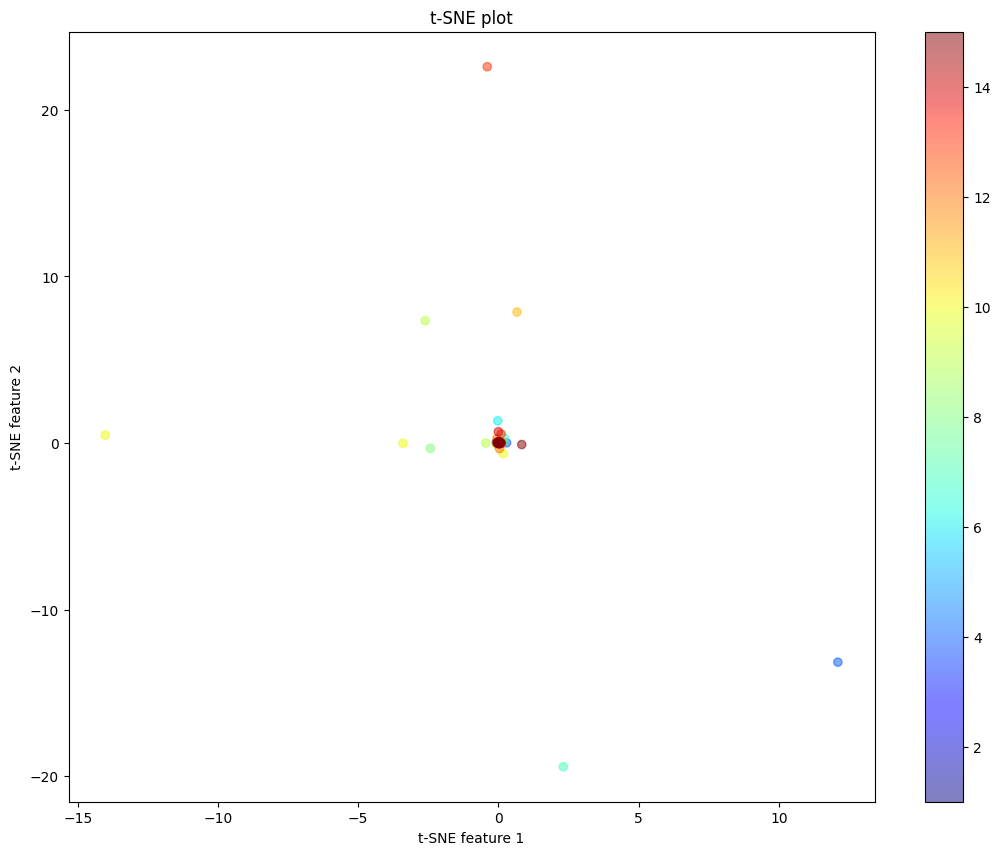

In [102]:
# Plotting the result
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y[:2000], cmap="jet", alpha=0.5)
plt.colorbar()
plt.title('t-SNE plot')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()
